In [1]:
## Generate data series
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import statsmodels.api as stm
import statsmodels.formula.api as smf


np.random.seed(1234567)
stochastic_baseline = np.random.normal (0, 0.5, 1440)
failure_stochastic = np.random.exponential(0.01, 1440)

In [2]:
def get_regression_line (mydf):

    myregr = smf.ols('failure_pctg ~ temperature', data = mydf)
    regression = myregr.fit()
    print(regression.summary())

    regression.params
    mydf['ols_fit'] = [regression.params[0] + regression.params[1] * mydf['temperature'][ii] 
                             for ii in range(len(mydf))]
    mydf.head()
    
    return (mydf)

In [3]:
def plot_temp (mydata, descr):
    ax1 = mydata.temperature.plot(c = 'r', figsize=(11,8.5))
    ax1.set_ylabel('Temperature', fontsize=16)
    # ax2 = ax1.twinx()
    ax1.set_title(descr + ' Temperature and Server Failure Percentage Time Series', fontsize=18)
    plt.show()

In [4]:
def plot_temp_fail_scatter (mydata, descr):
    fig, ax3 = plt.subplots(figsize=(11,8.5))
    sb.scatterplot(x = 'temperature', 
                   y = 'failure_pctg',
                   data = mydata, 
                   ax = ax3,
                   legend = 'full')
    if 'ols_fit' in mydata.columns:
        sb.scatterplot(x = 'temperature', 
                       y = 'ols_fit',
                       data = mydata,
                       ax = ax3,
                       legend = 'full'
                      )
    ax3.set_title (descr + ' Overall Server Failure Percentage vs. Temperature Scatter Plot', fontsize=18)
    ax3.set_ylabel ('Failure Probability', fontsize=16)    
    plt.show()

In [5]:
def plot_temp_fail_ts (mydata, descr):
    ax1 = mydata.temperature.plot(c = 'r', figsize=(11,8.5))
    ax1.set_ylabel('Temperature', fontsize=16)
    ax2 = ax1.twinx()
    ax2.spines['right'].set_position(('axes', 1.0))
    ax2.set_ylabel('Failure Percentage', fontsize=16)
    mydata.failure_pctg.plot(ax=ax2, c = 'b')
    ax1.set_title(descr + ' Temperature and Server Failure Percentage Time Series', fontsize=18)
    plt.show()

    

In [6]:
def plot_temp_fail_pctgs (mydata, descr):
    
    plot_temp_fail_ts (mydata, descr)
    plot_temp_fail_scatter (mydata, descr)
    

Data Generation

In [7]:
temperature = [stochastic_baseline[ii] + 80.0 for ii in range(len(stochastic_baseline))]
failure_pctg = [failure_stochastic[ii] for ii in range(len(failure_stochastic))]
dcOverAll = pd.DataFrame.from_dict({#'baseline': stochastic_baseline,
                                 'temperature': temperature,
                                 'failure_pctg': failure_pctg,
                                 'data_source': 'overall'})
dcOverAll['pt_num'] = dcOverAll.index
dcOverAll = get_regression_line(dcOverAll)

                            OLS Regression Results                            
Dep. Variable:           failure_pctg   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.2876
Date:                Fri, 04 Jan 2019   Prob (F-statistic):              0.592
Time:                        19:37:40   Log-Likelihood:                 4631.4
No. Observations:                1440   AIC:                            -9259.
Df Residuals:                    1438   BIC:                            -9248.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      -0.0127      0.042     -0.302      

In [8]:
# DataHall X: temperature grows
temperature = [stochastic_baseline[ii] + 80.0 + 0.005*ii for ii in range (len(stochastic_baseline))]
failure_pctg = [failure_stochastic[ii] + 0.00002*ii for ii in range (len(failure_stochastic))]

dhX = pd.DataFrame.from_dict({#'baseline': stochastic_baseline,
                                 'temperature': temperature,
                                 'failure_pctg': failure_pctg,
                                 'data_source': 'datahall_X'})

dhX['pt_num'] = dhX.index

dhX = get_regression_line(dhX)

                            OLS Regression Results                            
Dep. Variable:           failure_pctg   R-squared:                       0.414
Model:                            OLS   Adj. R-squared:                  0.413
Method:                 Least Squares   F-statistic:                     1015.
Date:                Fri, 04 Jan 2019   Prob (F-statistic):          6.25e-169
Time:                        19:37:41   Log-Likelihood:                 4607.1
No. Observations:                1440   AIC:                            -9210.
Df Residuals:                    1438   BIC:                            -9200.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      -0.3024      0.010    -29.482      

## Scenario 1:

A data center with tens of thousands of servers.  An important parameter is temperature, which sometimes is measured as the egress temperature of the air cooling the servers: overheat can lead to server failure.  So in our hypothetical scenario, let's say we are measuring temperature in the main egress manifold every minute for 24 hours.  Here is the plot:

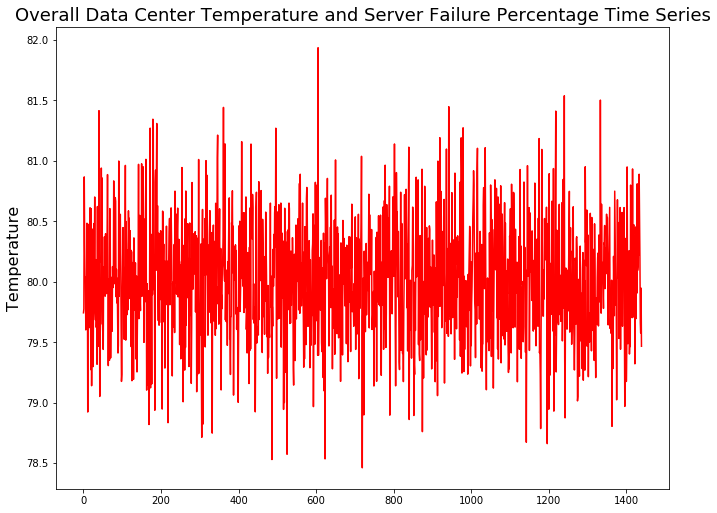

In [9]:
plot_temp (dcOverAll, 'Overall Data Center')

At the same time, in a mega-datacenter, servers do fail, get rebooted, restored, replaced, tech-refreshed, etc.  Let's assume that we are measuring the percentage of failed servers at the same timestamps as we are measuring temperatures (synchronizing timestamps is another interesting problem, but let's assume it's been solved).  Below is the time series plot showing temperature (red, left Y-axis) and failure perfentages(blue, right Y-axis) together:

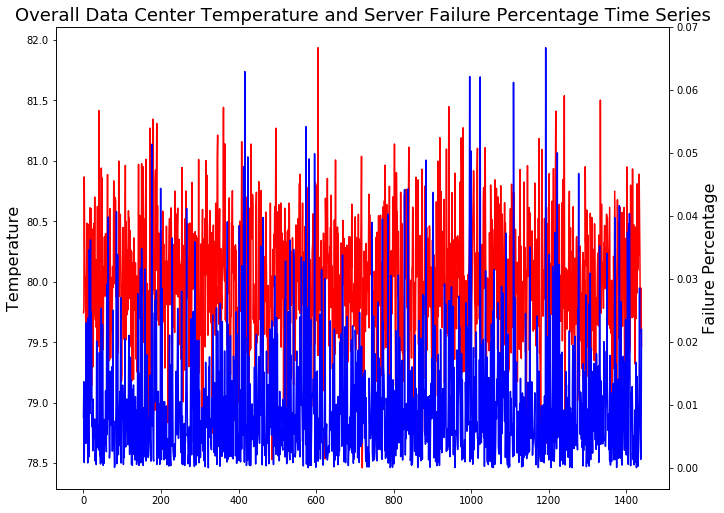

In [10]:
plot_temp_fail_ts(dcOverAll, 'Overall Data Center')

## Question:
Are failures and temperature correlated?  It's hard to tell from looking at the data as a time series.  Let's plot $Fail_{pct} = F(Temperature_{degreesF})$ and try to fit a regression line:

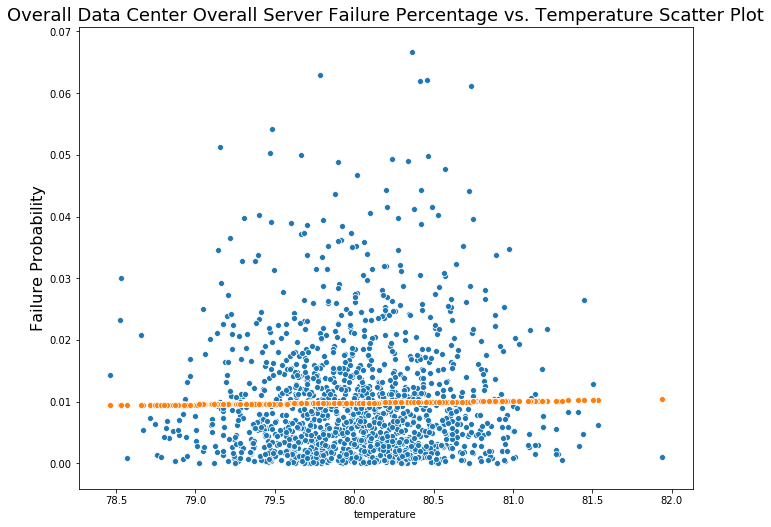

In [11]:
plot_temp_fail_scatter(dcOverAll, 'Overall Data Center')

There doesn't seem to be much correlation here: the line is flat; the $Failure_{Pct}$ points are all over the place. Can we quantify it?

The measure of relationship between two random variables is usually measured by [Pearson Correlation Coefficient](https://en.wikipedia.org/wiki/Pearson_correlation_coefficie1nt), 

$$\rho_{Y\_X} = \frac{cov(X,Y)}{\sigma_X * \sigma_Y}$$, 

where $cov(X,Y)$ is the covariance of $X$ and $Y$ (here temperature and failure percentage, respectively), and $\sigma$ is the standard deviation of the variable in its index.  

It takes values in the $\rho \in [-1...1]$ range and is positive when the variables increase in the same direction and negative when they increase in opposite directions.  

Linear (aka least-squares, or ordinary-least-squares) regression minimizes the sum of squares of the residuals ($resid = Y_{measured} - Y_{predicted}$); therefore, it makes sense to use squares of the covariance and the standard deviations, making the metric of correlation that's meaningful for regression: 


$$\left[\frac{cov(Y_{measured},Y_{predicted})}{\sigma_{Y_{measured}} * \sigma_{Y_{predicted}}}\right]^2 = \left({\rho_{measured\_predicted}}\right)^2$$, 

For regression goodness-of-fit, it became known as $R^2$.

In [12]:
myregr = smf.ols('failure_pctg ~ temperature', data = dcOverAll)
regression = myregr.fit()

In this case, $R^2$ is:

In [13]:
print ('R-Squared: %10.6s' % (regression.rsquared))

R-Squared:     0.0001


Another way to tell if there is a correlation is to look at the regression-line parameters. 

When we fit a regression line into data, we try to find parameters, $\beta_0$ and $\beta_1$, of the equation: 

$$Y = \beta_0 + \beta_1 * X + \epsilon$$, 

that will minimize a metric based on the $\epsilon$, (e.g., $\sum{\left(Y' - Y\right)^2}$).  When $\beta_0$ is insignificant, it doesn't convey any useful information other than that the line we have fitted into the data probably has a $Y$-intercept equal 0: $Y(X=0) = 0$.  But the significance of the $\beta_1$ is very important: it is the arctangent of the slope that the line makes with the $X$-axis.  $\beta_1 = 0$ means that the line is flat - which is what we have seen in the Figure above.

It makes sense to assume that there is a relationship between $R^2$ and $\beta_1$.  Indeed, mathematical derivations lead to:

$$\beta_1 = \rho_{Y\_X} * \frac{\sigma_Y}{\sigma_X}$$

In this case, regression-line parameters are:

In [14]:
print (regression.params)

Intercept     -0.012708
temperature    0.000282
dtype: float64


We see that $\beta_0 \neq 0$, and $\beta-1 \neq 0$, but are they sufficiently far from $0$?

Here we have to use a technique called statistical testing.

We formulate a $\textit{null-hypothesis}, H_0$, and then use the data to prove it wrong.  If we cannot prove it wrong, we accept it "until further evidence proves it wrong".  Otherwise, we reject it and accept the $\textit{alternative hypothesis}, H_a$.  For regression parameters, the null hypothesis is that the parameter is 0:

$$H_0: \beta_1 = 0$$.  To validate it, we use the $\textit {T-test}$, computing 

$$T = \frac{\beta_1 -0}{\frac{\sigma_{resid}}{\sqrt{N_{df}}}}$$:

the distance of $\beta_1$ from $0$ scaled by the standard deviation of the residuals and multiplied by the number of degrees of freedom.  Then, if $|T|$ is less than a $T_{critical}$, computed for a given number of degrees of freedom and confidence level (e.g., we want to be 95% confident that $H_0$ is true; $\alpha = 0.95$), then we can accept $H_0$ with the confidence level of $\alpha$.  If, on the other hand,  $|T|$ is greater than $T_{critical}$, we have to reject it: we cannot be 95% sure that $\beta_1 = 0$.

In [15]:
print(regression.tvalues)

Intercept     -0.302367
temperature    0.536277
dtype: float64


Naturally, in and of themselves the T-values are not useful: we need to know the corresponding $T_{critical}$.

However, we can also estimate the confidence level $\alpha$, or rather $p_{value} = 1-\alpha$:

In [16]:
print(regression.pvalues)

Intercept      0.762416
temperature    0.591850
dtype: float64


If p-value is less than the chosen signficance level (e.g., $p = 0.05$), it means that there is a less than $5\%$ chance that the estimate of $\beta_1 = 0$ by a random "roll of the dice".  Then we have to reject the $H_0$ and accept the $H_a: \beta_1 \neq 0$.

In the scenario we are analyzing, $p_{temperature} = 0.591 > 0.05$; therefore, we accept $H_0$.  Temperature parameter is insignificant.

## What's all this got to do with Machine Learning?

Everything.  The logic outlined above can be codified to "train" the machine to distinguish correlated variables from uncorrelated variables.  It can also be used to find, out of $N$ models or $M$ regression types (there are about 20 different regression types, from OLS (Ordinary Least-Squares, aka Linear) to things as sophisticated as Quantile Regression to Lasso, Ridge, and Logistic regression.  

Using the same regression model on data it has not seen "in training" can measure (again, using metrics as simple as $\beta_0$, $\beta_1$, and $R^2$) its ability to generalize the patterns inferred from the training data.

## Scenario 2:

Now let's pretend that we have a data hall $dhX$ in our hypothetical datacenter where the temperature is on the rise.  We also observe failure percentages growing in this data hall.  Unless we have a causal model, we do not know that temperature is the explanatory variable for server failures, but let's see if we can find a correlation.

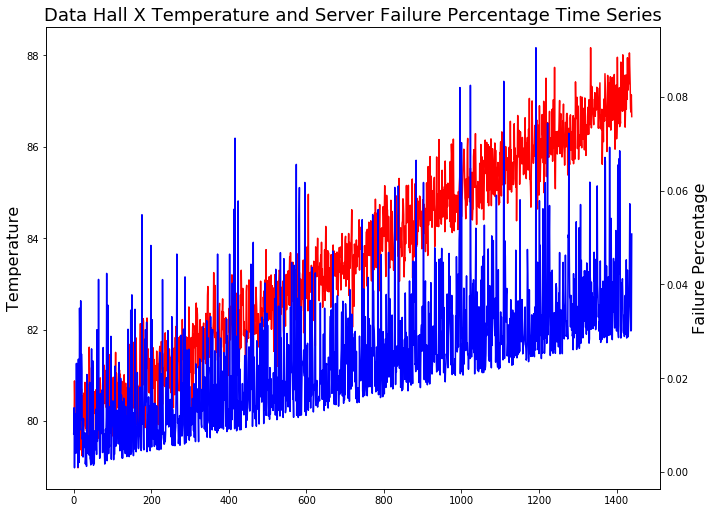

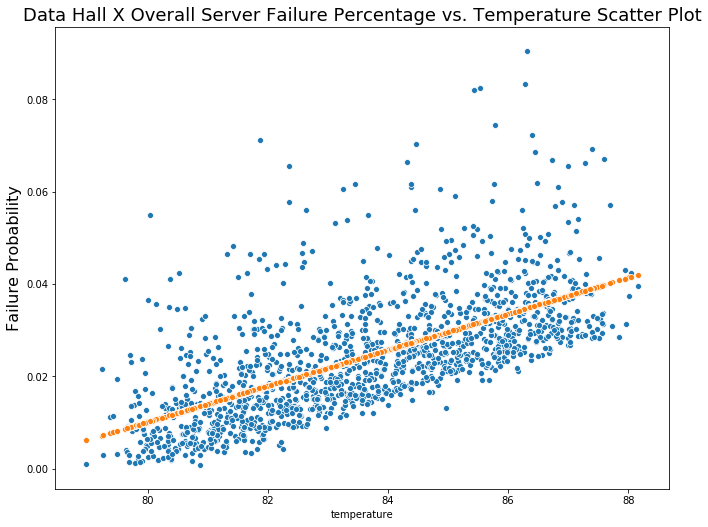

In [17]:
# DataHall X: temperature grows
plot_temp_fail_pctgs (dhX, 'Data Hall X')

### Scenario 2 Discussion

We see that there is a linear relationship between temperature and failure percentage in this scenario.  With less than $1\%$ of servers down, it is very unreasonable to suggest that the causality goes from server failures to temperature rise.  It is more likely to be the way we have displayed in the Figure above.

Let's explore the data:

In [18]:
myregr = smf.ols('failure_pctg ~ temperature', data = dhX)
regression = myregr.fit()
print ('R-squared: %5.3f' % (regression.rsquared))

print ('parameter significance:')
print (regression.pvalues)

R-squared: 0.414
parameter significance:
Intercept      8.019322e-150
temperature    6.246228e-169
dtype: float64


For this data set, the model explains $R^2 = 41.4\%$ of the variance in the failure percentage.  Considering that this is a univariate model (temperature is the only explanatory variable), this suggests that there may be other metris that have an effect on the failure probability: CPU load, memory utilization, storage IOPS, etc.  But the temperature itself in this case is an important factor.

We also see that the temperature parameter is significant: $p_{temperature} \ll 10^{-3}$.

And we see that the intercept is significant: $p_{intercept} \ll 10^{-3}$.   
This is important: it suggests that when temperature is 0 degrees Fahrenheit, failure probability will be $Pr\{failure\} = -0.3\% < 0$.

### For Logistic Regression - see [example2](http://localhost:8888/notebooks/Dropbox/Intro%20to%20Machine%20Learning%20at%20CMG%202019/Worksheets/ipynb/example2%20-%20Logistic%20Regression.ipynb)

Different statistical tools return different regression summaries, but the parameter statistics and $R^2$ are always present.  

The output from python's $\textbf{statsmodels}$ package is provided in provided below:

In [19]:
regression.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           failure_pctg   R-squared:                       0.414
Model:                            OLS   Adj. R-squared:                  0.413
Method:                 Least Squares   F-statistic:                     1015.
Date:                Fri, 04 Jan 2019   Prob (F-statistic):          6.25e-169
Time:                        19:37:43   Log-Likelihood:                 4607.1
No. Observations:                1440   AIC:                            -9210.
Df Residuals:                    1438   BIC:                            -9200.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      -0.3024      0.010    -29.482      0.000      -0.323      -0.282
temperature     0.0039      0.000     31.853      0.000       0.004       0.004
==============================================================================
Omnibus:                      541.224   Durbin-Watson:                   1.976
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2040.130
Skew:                           1.824   Prob(JB):                         0.00
Kurtosis:                       7.550   Cond. No.                     3.30e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.3e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Now $R^2 = 41.4\%$ of the variance in failure percentage are explained by temperature.  Both $\beta_0$ and $\beta_1$ are significant, and we can start looking for other variables that explain the growth in failure probability.

In [20]:
## Combine the data:
mydata = pd.concat([dcOverAll, dhX])
mydata.to_csv('./csvs/temp_and_failure_prob.csv', index=False)